# 14.1 格子細胞のデコーディング

## 14.1.1 グリッド細胞(Grid Cells)について

### 空間基底としてのグリッド細胞
海馬には場所特異的に発火する**場所細胞**(place cell)があり、これはO'keefeによって発見された。次にMay-Britt MoserとEdvard Moserが六角形格子状の場所受容野を持つ**グリッド細胞**(格子細胞, grid cell)を内側嗅内皮質(medial entorhinal cortex; MEC)で発見した。この3人は2014年のノーベル生理学・医学賞を受賞している。

### データについて

Moser研が公開している、格子細胞の活動データは<https://www.ntnu.edu/kavli/research/grid-cell-data>からダウンロードできる。公開されているデータはMatLabのmatファイル形式である。

使用するデータは以下の通り。

- [10704-07070407_POS.mat](https://github.com/Salad-bowl-of-knowledge/hp/blob/master/_notebooks/data/grid_cells_data/10704-07070407_POS.mat)
- [10704-07070407_T2C3.mat](https://github.com/Salad-bowl-of-knowledge/hp/blob/master/_notebooks/data/grid_cells_data/10704-07070407_T2C3.mat)

これらのファイルは<https://archive.norstore.no/pages/public/datasetDetail.jsf?id=8F6BE356-3277-475C-87B1-C7A977632DA7>からダウンロードできるファイルの一部である。以下では`./data/grid_cells_data/`ディレクトリの下にファイルを置いている。

データの末尾の"POS"と"T2C3"の意味について説明しておく。まず、"POS"はpost, posx, posyを含む構造体でそれぞれ試行の経過時間、x座標, y座標である。座標は$[-50, 50]$で記録されています。1m四方の正方形の部屋で、原点を部屋の中心としている。"T2C3"はtがtetrode（テトロード電極）でcがcell（細胞）を意味する。後ろの数字は番号付けである。 

## 14.1.2 ラットの行動軌跡と発火の描画

データを読み込む。

In [1]:
using MAT

In [2]:
# from http://www.ntnu.edu/kavli/research/grid-cell-data
pos = matopen("../_static/datasets/grid_cells_data/10704-07070407_POS.mat")
spk = matopen("../_static/datasets/grid_cells_data/10704-07070407_T2C3.mat")

MAT.MAT_v5.Matlabv5File(IOStream(<file ../_static/datasets/grid_cells_data/10704-07070407_T2C3.mat>), false, #undef)

In [43]:
using PyPlot

posファイル内の構造は次のようになっている。
- `pos["post"]`: times at which positions were recorded
- `pos["posx"]`: x positions
- `pos["posy"]`: y positions
- `spk["cellTS"]`: spike times

In [24]:
post = read(pos, "post")[:] #  times at which positions were recorded
posx = read(pos, "posx")[:] #x positions
posy = read(pos, "posy")[:] # y positions
spkt = read(spk, "cellTS")[:] #spike time

println(size(post), size(posx), size(posy), size(spkt))

(30000,)(30000,)(30000,)(2326,)


行動軌跡を描画する。

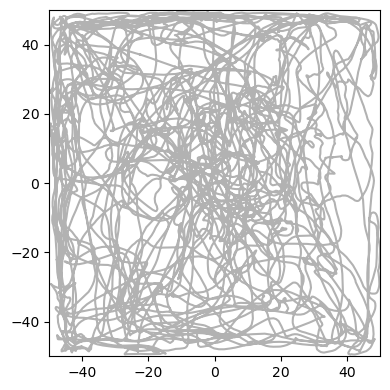

In [16]:
figure(figsize=(4,4))
plot(posx, posy, color="k", alpha=0.3)
xlim(-50, 50); ylim(-50, 50)
tight_layout()

発火を描画するために発火時刻 `spkt` のそれぞれの要素と最も近い `post` のインデックスを求める関数を実装する。

In [27]:
function nearest_pos(array, value)
    idx = argmin(abs.(array .- value))
    return idx
end

nearest_pos (generic function with 1 method)

In [42]:
idx = [nearest_pos(post, t) for t in spkt]

println("post : ", post[1:3])
println("spkt : ", spkt[1])
println("idx  : ", idx[1])

post : [0.0, 0.01999999999998181, 0.03999999999996362]
spkt : 0.010260416666666666
idx  : 2


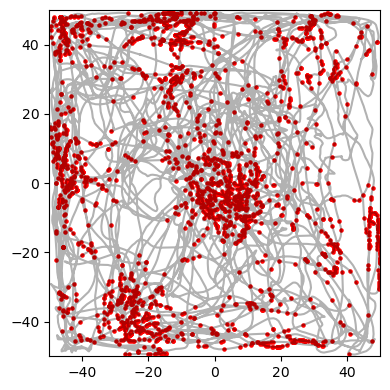

In [33]:
figure(figsize=(4,4))
plot(posx, posy, color="k", alpha=0.3)
scatter(posx[idx], posy[idx], color="r", s=5)
xlim(-50, 50); ylim(-50, 50)
tight_layout()

発火数のヒストグラムを描画する。

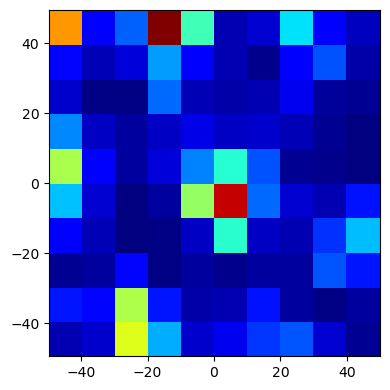

In [132]:
figure(figsize=(4,4))
hist2D(posx[idx], posy[idx], bins=10, cmap="jet")
tight_layout()

## 14.1.3 Smoothed Rate Map

発火率$\lambda(\boldsymbol{x})$は、場所$\boldsymbol{x}=(x,y)$で記録されたスパイクの回数を、場所$\boldsymbol{x}$における滞在時間(s)で割ることで得られる。 

$$ 
\lambda(\boldsymbol{x})=\frac{\displaystyle \sum_{i=1}^n
g\left(\frac{\boldsymbol{s}_i-\boldsymbol{x}}{h}\right)}{\displaystyle \int_0^T g\left(\frac{\boldsymbol{y}(t)-\boldsymbol{x}}{h}\right)dt} 
$$ 

ただし、$n$はスパイクの回数、$T$は計測時間、$g(\cdot)$はGaussain
Kernel（中身の分子が平均、分母が標準偏差）、$\boldsymbol{s}_i$は$i$番目のスパイクの発生した位置、$\boldsymbol{y}(t)$は時刻$t$でのラットの位置である。分母は積分になっているが、実際には離散的に記録をするので、累積和に変更し、$dt$を時間のステップ幅(今回は0.02s)とする。

In [127]:
function Gaussian2d(x0, y0, sizex=100, sizey=100, sigma=5)
    x = 0:sizex-1
    y = 0:sizey-1
    Y = [i for i in y, j in 1:length(x)]
    X = [j for i in 1:length(y), j in x]
    
    mask = exp.(-((X .- x0) .^2 + (Y .- y0) .^2) / (2.0*(sigma^2)))
    return mask ./ sum(mask)
end

Gaussian2d (generic function with 6 methods)

In [161]:
H = 100
W = 100

# occup position while trajectory 
occup_map = zeros(H, W)
for i in 1:size(posx)[1]
    x = posx[i] + 50
    y = posy[i] + 50
    occup_map += Gaussian2d(x, y)
end

occup_map *= 0.02 # one time step is 0.02s 
occup_map[occup_map .== 0] .= 1 # avoid devide by zero

# activation
activ_map = zeros(H, W)
for i in idx
    x = posx[i] + 50
    y = posy[i] + 50
    activ_map += Gaussian2d(x, y)
end

rate_map = activ_map ./ occup_map

println(size(rate_map))

100×100 Array{Float64,2}:
  0.267417   0.285621   0.307304   0.333142  …  0.542294  0.53494   0.534283
  0.304747   0.323633   0.346225   0.37327      0.534453  0.529406  0.530801
  0.34926    0.368635   0.39193    0.419971     0.529054  0.526057  0.529241
  0.402779   0.422384   0.446098   0.474836     0.526694  0.525559  0.530348
  0.467507   0.487009   0.510773   0.53981      0.528281  0.52895   0.535304
  0.545966   0.564964   0.588325   0.617165  …  0.53519   0.537837  0.545976
  0.640832   0.658877   0.681318   0.709376     0.549511  0.554702  0.56528
  0.754626   0.771257   0.792232   0.818881     0.574418  0.583351  0.597731
  0.889249   0.904056   0.923057   0.947685     0.614681  0.629535  0.650178
  1.04542    1.05812    1.07475    1.09685      0.67732   0.701699  0.732652
  1.2221     1.2326     1.24668    1.26593   …  0.772265  0.811661  0.859028
  1.41605    1.42456    1.43616    1.4525       0.912704  0.974776  1.04694
  1.62161    1.62861    1.63813    1.65184      1.11

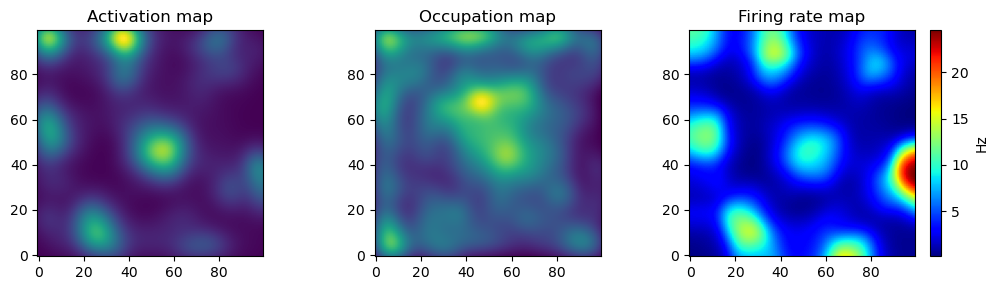

In [246]:
figure(figsize=(10.5, 3))
subplot(1,3,1)
title("Activation map")
imshow(activ_map)
gca().invert_yaxis()

subplot(1,3,2)
title("Occupation map")
imshow(occup_map)
gca().invert_yaxis()

subplot(1,3,3)
title("Firing rate map")
imshow(rate_map, cmap="jet")
colorbar(label="Hz")
gca().invert_yaxis()

tight_layout()

## 14.1.4 Autocorrelation Map

2次元の自己相関マップ (autocorrelation map)を描画する。これにはPythonのライブラリ `scipy.signal` を用いると簡便である。

In [230]:
using PyCall
sc = pyimport("scipy.signal")

PyObject <module 'scipy.signal' from 'C:\\Users\\yamta\\.julia\\conda\\3\\lib\\site-packages\\scipy\\signal\\__init__.py'>

In [277]:
corr_map = sc.correlate2d(rate_map, rate_map, fillvalue=4)

println(size(corr_map))

(199, 199)


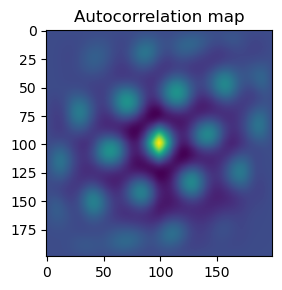

In [278]:
figure(figsize=(3, 3))
title("Autocorrelation map")
imshow(corr_map)
tight_layout()

## 参考にした文献・サイト
- <https://github.com/Felix11H/grid_cell_rate_map>
- <https://www.ntnu.edu/kavli/research/grid-cell-data>
- <https://core.ac.uk/download/pdf/30859910.pdf>のSupporting Online Material
- <https://github.com/MattNolanLab/gridcells>
- <https://arxiv.org/pdf/1810.07429.pdf>
- <https://www.diogosantospata.com/gridcells/>